# Assignment 5

In this assignment, you'll scrape text from [The California Aggie](https://theaggie.org/) and then analyze the text.

The Aggie is organized by category into article lists. For example, there's a [Campus News](https://theaggie.org/campus/) list, [Arts & Culture](https://theaggie.org/arts/) list, and [Sports](https://theaggie.org/sports/) list. Notice that each list has multiple pages, with a maximum of 15 articles per page.

The goal of exercises 1.1 - 1.3 is to scrape articles from the Aggie for analysis in exercise 1.4.

In [1]:
import requests
import requests_ftp
import requests_cache
import urllib
import lxml
from bs4 import BeautifulSoup
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
import re

#Plots
plt.style.use('ggplot')
requests_cache.install_cache("cache")
from fastcache import lru_cache
%matplotlib inline
import seaborn as sns

#NLTK and word processing
import nltk
from nltk import corpus
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import random
from wordcloud import WordCloud, STOPWORDS
from itertools import izip

__Exercise 1.1.__ Write a function that extracts all of the links to articles in an Aggie article list. The function should:

* Have a parameter `url` for the URL of the article list.

* Have a parameter `page` for the number of pages to fetch links from. The default should be `1`.

* Return a list of article URLs (each URL should be a string).

Test your function on 2-3 different categories to make sure it works.

Hints:

* Be polite to The Aggie and save time by setting up [requests_cache](https://pypi.python.org/pypi/requests-cache) before you write your function.

* Start by getting your function to work for just 1 page. Once that works, have your function call itself to get additional pages.

* You can use [lxml.html](http://lxml.de/lxmlhtml.html) or [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to scrape HTML. Choose one and use it throughout the entire assignment.

In [2]:
@lru_cache(maxsize=128, typed=False)
def subLinks(url):
    """
    accept the list url as an argument and 
    return a corresponding list of article urls (for 0 items, return an empty list)
    """
    ag_req = requests.get(url)
    aghtml = ag_req.text
    ag = BeautifulSoup(aghtml, 'lxml') #for processing
    urls = [x.findNext().get('href') for x in ag.findAll('h2')] #use h2 because every link within h2 are the only relevant articles
    return urls
#subLinks("http://theaggie.org/sciencetech")
#subLinks("http://theaggie.org/opinion")
#subLinks("http://theaggie.org/sports)
#subLinks("http://theaggie.org/arts")


In [3]:
def pageLinks(url, page=1): #default is 1 page
    link = [subLinks(url + "/page/" + str(i)) for i in range(1, page + 1)] #constructs a link you can query
    return(link)
#pageLinks("http://theaggie.org/arts", 2) #Just returns [None] if you try to query a number greater than the number of pages the aggie has

__Exercise 1.2.__ Write a function that extracts the title, text, and author of an Aggie article. The function should:

* Have a parameter `url` for the URL of the article.

* For the author, extract the "Written By" line that appears at the end of most articles. You don't have to extract the author's name from this line.

* Return a dictionary with keys "url", "title", "text", and "author". The values for these should be the article url, title, text, and author, respectively.

In [17]:
def aggiedict(url): 
    r = requests.get(url)
    html = r.text
    article = BeautifulSoup(html, 'lxml')
    
    adict = {'author':'','text':'','title':'','url':''} #different sections 
    adict['title'] = article.find_all('h1',attrs={'class':'entry-title'})[0].get_text() #pulls out the first element in h1
    adict['url'] = url

    body = article.find_all("div", {'itemprop': 'articleBody'})[0] #itemprop is where the body text can be found from the website's html
    paragraph = body.find_all('p')
    
    text = " ".join([x.getText() for x in paragraph[:-1]]) #joins the list because you run a list comprehension
    #text = "".join(text.translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })) #unicode characters
    adict['text'] = text
        
    auth = paragraph[len(paragraph)-1].getText() #leave out the last line because it has "written by"
    auths = re.split("Written [Bb]y", auth, flags=re.IGNORECASE)[-1] #get the author's name 
    author = ", ".join(re.findall("[A-Z][a-z]+ [A-Z][a-z]+", auths, flags=re.IGNORECASE))
    adict['author'] = author
    return type(paragraph)

aggiedict("https://theaggie.org/2016/11/07/cannabis-cultivation-permit-problems-persist/")
#aggiedict("https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/")
#aggiedict("https://theaggie.org/2017/02/21/looking-for-life-on-other-planets/") #other text
#aggiedict("https://theaggie.org/2017/02/20/question-the-value-of-private-and-charter-schools/") #disclaimer is below written by
#aggiedict("https://theaggie.org/2017/02/21/gary-may-a-promising-pick-for-chancellor/") #no author
#aggiedict("https://theaggie.org/2017/02/20/city-of-davis-awarded-funds-for-new-recycling-bins/")
#aggiedict("https://theaggie.org/2017/02/21/uc-davis-experiences-several-recent-hate-based-crimes/")

bs4.element.ResultSet

For example, for [this article](https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/) your function should return something similar to this:
```
{
    'author': u'Written By: Bianca Antunez \xa0\u2014\xa0city@theaggie.org',
    'text': u'Davis residents create financial model to make city\'s financial state more transparent To increase transparency between the city\'s financial situation and the community, three residents created a model called Project Toto which aims to improve how the city communicates its finances in an easily accessible design. Jeff Miller and Matt Williams, who are members of Davis\' Finance and Budget Commission, joined together with Davis entrepreneur Bob Fung to create the model plan to bring the project to the Finance and Budget Commission in February, according to Kelly Stachowicz, assistant city manager. "City staff appreciate the efforts that have gone into this, and the interest in trying to look at the city\'s potential financial position over the long term," Stachowicz said in an email interview. "We all have a shared goal to plan for a sound fiscal future with few surprises. We believe the Project Toto effort will mesh well with our other efforts as we build the budget for the next fiscal year and beyond." Project Toto complements the city\'s effort to amplify the transparency of city decisions to community members. The aim is to increase the understanding about the city\'s financial situation and make the information more accessible and easier to understand. The project is mostly a tool for public education, but can also make predictions about potential decisions regarding the city\'s financial future. Once completed, the program will allow residents to manipulate variables to see their eventual consequences, such as tax increases or extensions and proposed developments "This really isn\'t a budget, it is a forecast to see the intervention of these decisions," Williams said in an interview with The Davis Enterprise. "What happens if we extend the sales tax? What does it do given the other numbers that are in?" Project Toto enables users, whether it be a curious Davis resident, a concerned community member or a city leader, with the ability to project city finances with differing variables. The online program consists of the 400-page city budget for the 2016-2017 fiscal year, the previous budget, staff reports and consultant analyses. All of the documents are cited and accessible to the public within Project Toto. "It\'s a model that very easily lends itself to visual representation," Mayor Robb Davis said. "You can see the impacts of decisions the council makes on the fiscal health of the city." Complementary to this program, there is also a more advanced version of the model with more in-depth analyses of the city\'s finances. However, for an easy-to-understand, simplistic overview, Project Toto should be enough to help residents comprehend Davis finances. There is still more to do on the project, but its creators are hard at work trying to finalize it before the 2017-2018 fiscal year budget. "It\'s something I have been very much supportive of," Davis said. "Transparency is not just something that I have been supportive of but something we have stated as a city council objective [ ] this fits very well with our attempt to inform the public of our challenges with our fiscal situation." ',
    'title': 'Project Toto aims to address questions regarding city finances',
    'url': 'https://theaggie.org/2017/02/14/project-toto-aims-to-address-questions-regarding-city-finances/'
}
```

Hints:

* The author line is always the last line of the last paragraph.

*   Python 2 displays some Unicode characters as `\uXXXX`. For instance, `\u201c` is a left-facing quotation mark.
    You can convert most of these to ASCII characters with the method call (on a string)
    ```
    .translate({ 0x2018:0x27, 0x2019:0x27, 0x201C:0x22, 0x201D:0x22, 0x2026:0x20 })
    ```
    If you're curious about these characters, you can look them up on [this page](http://unicode.org/cldr/utility/character.jsp), or read 
    more about [what Unicode is](http://unicode.org/standard/WhatIsUnicode.html).

__Notes:__ "The author line is always the last line of the last paragraph" is simply not true. On some opinion places, there's a "disclaimer" line after that, and so on. For example, this link "https://theaggie.org/2017/02/20/question-the-value-of-private-and-charter-schools/" does not return the correct information. Basically if the formatting strays even slightly from what I have, this will not work, so it doesn't work for a lot of the humor sections where there are disclaimers or any extraneous notes in the body after the "Written By" line. 

__Exercise 1.3.__ Use your functions from exercises 1.1 and 1.2 to get a data frame of 60 [Campus News](https://theaggie.org/campus/) articles and a data frame of 60 [City News](https://theaggie.org/city/) articles. Add a column to each that indicates the category, then combine them into one big data frame.

The "text" column of this data frame will be your corpus for natural language processing in exercise 1.4.

In [6]:
campuslist = pageLinks("http://theaggie.org/campus", 4) #There are 15 on each page from running the length of each list. We want the first 60
citylist = pageLinks("http://theaggie.org/city", 4)

campus = [item for sublist in campuslist for item in sublist] 
city = [item for sublist in citylist for item in sublist]

#campus_df = pd.DataFrame(aggiedict(x) for x in campus) #Create a dataframe
##campus_df.loc[:,'category'] = "campus"
#city_df = pd.DataFrame([aggiedict(x) for x in city])
#city_df.loc[:,'category'] = "city"

In [7]:
campus_list = [aggiedict(x) for x in campus] 
campus_df = pd.DataFrame(campus_list)
campus_df.loc[:,'category'] = "campus"
city_list = [aggiedict(x) for x in city] 
city_df = pd.DataFrame(city_list)
city_df.loc[:,'category'] = "city"

In [8]:
articles_df = campus_df.append(city_df)
articles_df

,author,text,title,url,category
0,Alyssa Vandenberg,"Shaheen's name to remain on ballot, his votes ...",Senate candidate Zaki Shaheen withdraws from race,https://theaggie.org/2017/02/22/senate-candida...,campus
1,Aaron Liss,Students receive email warnings from UC Davis ...,UC Davis experiences several recent hate-based...,https://theaggie.org/2017/02/21/uc-davis-exper...,campus
2,Alyssa Vandenberg,UC Board of Regents to vote on the appointment...,UC President selects Gary May as new UC Davis ...,https://theaggie.org/2017/02/21/uc-president-s...,campus
3,Jeanna Totah,Tighter policies require greater approval of o...,Katehi controversy prompts decline of UC admin...,https://theaggie.org/2017/02/20/katehi-controv...,campus
4,Ivan Valenzuela,SR #7 asks university to increase capacity for...,ASUCD Senate passes resolution submitting comm...,https://theaggie.org/2017/02/20/asucd-senate-p...,campus
5,Yvonne Leong,UC Davis leads in sustainability with largest ...,UC releases 2016 Annual Report on Sustainable ...,https://theaggie.org/2017/02/20/uc-releases-20...,campus
6,Kenton Goldsby,"Speakers, including Interim Chancellor Ralph J...",UC Davis Global Affairs holds discussion on Pr...,https://theaggie.org/2017/02/19/uc-davis-globa...,campus
7,Kimia Akbari,Executive order has immediate consequences for...,Trump’s immigration ban affects UC Davis commu...,https://theaggie.org/2017/02/19/trumps-immigra...,campus
8,Kaitlyn Cheung,Student protesters march from MU flagpole to M...,UC Davis students participate in UC-wide #NoDA...,https://theaggie.org/2017/02/17/uc-davis-stude...,campus
9,Jayashri Padmanabhan,"Conference entails full day of speakers, panel...",UC Davis holds first mental health conference,https://theaggie.org/2017/02/17/uc-davis-holds...,campus


__Exercise 1.4.__ Use the Aggie corpus to answer the following questions. Use plots to support your analysis.

* What topics does the Aggie cover the most? Do city articles typically cover different topics than campus articles?

* What are the titles of the top 3 pairs of most similar articles? Examine each pair of articles. What words do they have in common?

* Do you think this corpus is representative of the Aggie? Why or why not? What kinds of inference can this corpus support? Explain your reasoning.

Hints:

*   The [nltk book](http://www.nltk.org/book/) and [scikit-learn documentation](http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) may be helpful here.

*   You can determine whether city articles are "near" campus articles from the similarity matrix or with k-nearest neighbors.

*   If you want, you can use the [wordcloud](http://amueller.github.io/word_cloud/) package to plot a word cloud. To install the package, run
    ```
    conda install -c https://conda.anaconda.org/amueller wordcloud
    ```
    in a terminal. Word clouds look nice and are easy to read, but are less precise than bar plots.

__Intro:__ Let's first start with some word clouds. I'm going to use this to visualize which words or topics The Aggie's article titles cover the most, at least in campus and city news (combined). Since word clouds are useful more for visualization than for analysis, after this, I'll further break down each category separately. 

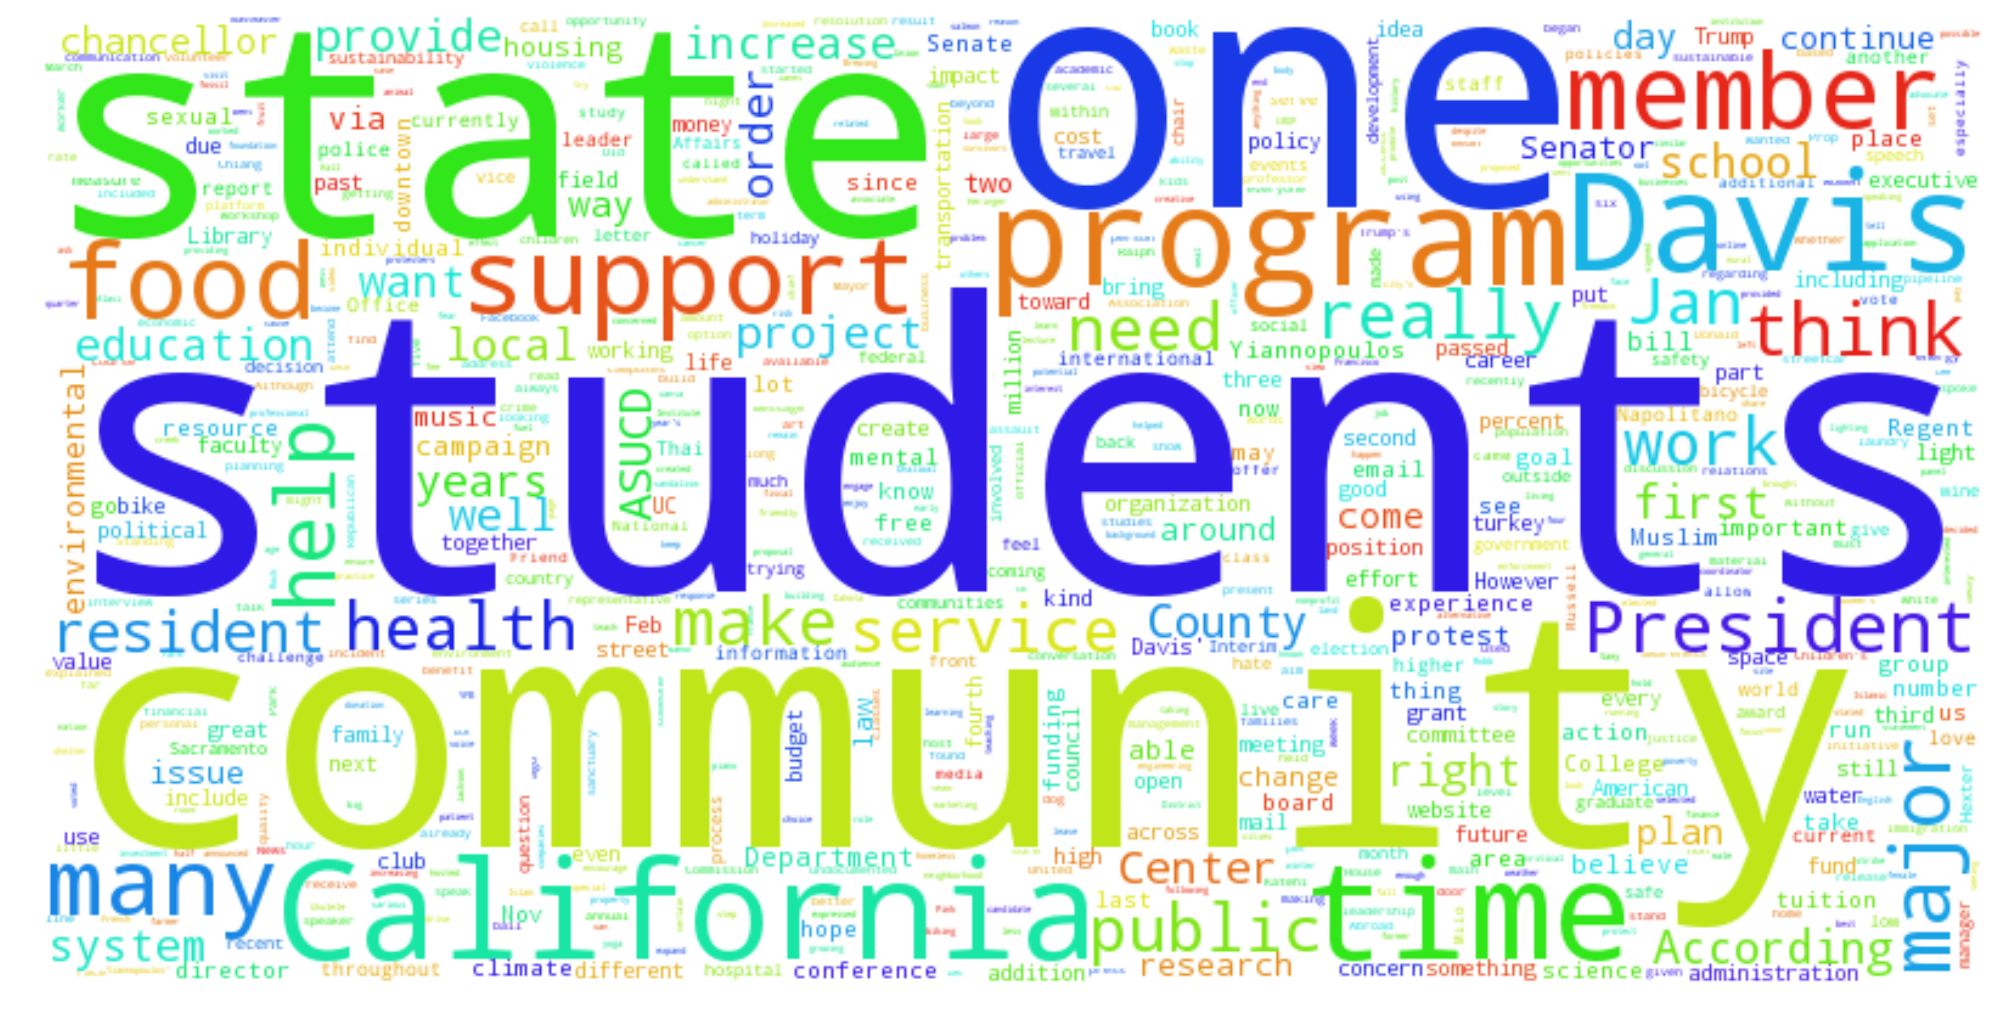

In [9]:
the_stopwords = set(["university", "event", "UC", "Logs", "Davis", "Day", "Police", "Yolo", "city", "campus", "said", "the", "will", 
                    "going", "is", "says", "also", "year", "student", "new", "s", "t", "people", "Sacramento" ])
stopwords = set(STOPWORDS).union(the_stopwords)
textcloud = list((" ".join(articles_df["text"])).split(" "))
interested = " ".join([item for item in textcloud if item not in stopwords])

image = WordCloud(background_color = "white", max_words=800, stopwords=stopwords, width=800, height=400) #Background for wordcloud
image.generate(interested) #Gets the image

#Display plot
plt.figure(figsize=(25,10))
plt.imshow(image)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Some topics are food, support, program, and major, which makes sense for many reasons. The Aggie dedicates a few staff writers to examine food picks in Davis, and there are a lot of articles which describe local events, which would explain the prevalence of support and program. Also, students interviewed are often asked for their majors, making it relevant to the word cloud.

In [10]:
findWords = [re.findall(r'\w+', campus_df['text'][x]) for x in range(len(campus_df))] #gets the words from the text section
words1 = [item for sublist in findWords for item in sublist]
resultwords  = [word for word in words1 if word.lower() not in stopwords] #accounts for stopwords
res_words = Counter(resultwords).most_common()[0:20] #First 20 results for each category, counted
comcamp = pd.DataFrame(res_words, columns = ["words","count"]) #Put into dataframe

findWords2 = [re.findall(r'\w+', city_df['text'][x]) for x in range(len(city_df))]
words2 = [item for sublist in findWords2 for item in sublist]
resultwords2  = [word for word in words2 if word.lower() not in stopwords]
res_words2 = Counter(resultwords2).most_common()[0:20]
comcity = pd.DataFrame(res_words2, columns = ["words","count"])

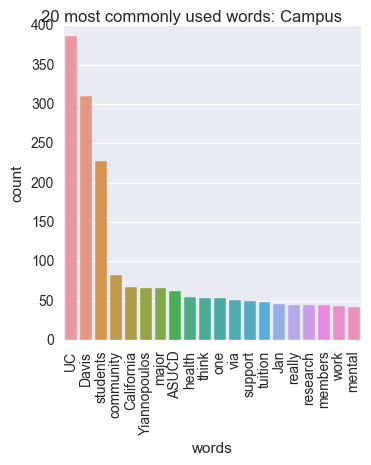

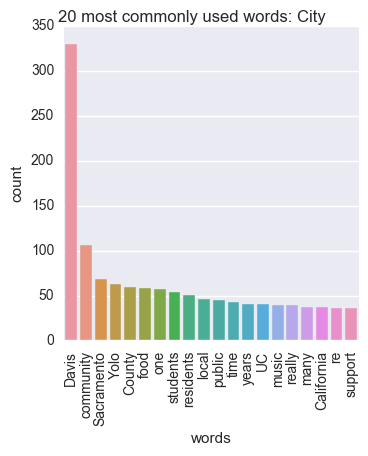

In [11]:
exp = sns.factorplot("words", "count", data = comcamp, kind = "bar") 
exp.set_xticklabels(rotation=90) #Rotate axis labels so they don't overlap
exp.fig.suptitle('20 most commonly used words: Campus')
plt.show(exp)

exp2 = sns.factorplot("words", "count", data = comcity, kind = "bar")
exp2.set_xticklabels(rotation=90) #Rotate axis labels so they don't overlap
exp2.fig.suptitle('20 most commonly used words: City')
plt.show(exp2)

__Notes:__ As you can see, there are a few things that are repeated within every Aggie article (which is why we try to use them as stopwords). These are words like Davis, Sacramento, Yolo, etc. which make sense because they are Davis-specific. A few things that stand out besides that is that Campus news is a lot more political on the surface, with current events that affect Davis's atmosphere (e.g. Yiannopoulous, ASUCD, and tuition), whereas City news is more general and has words like "local" and "public" and a lot more references to Sacramento/Yolo. 

__Preface/Works Cited:__ The following code from here till the end of the assignment is taken entirely from a peer (Edie Espejo, smartest person in the class). I am including it because I believe that any resources that are available should be capitalized for analyzing data, and it is not something I completely understand. I am in the process of doing so. Hopefully this class does a better job of bridging that gap so I can be more self-reliant, but for now, behold the similarities matrix.

In [19]:
# CREATE VECTORIZER
vectorizer = TfidfVectorizer(tokenizer=lemmatize, stop_words=stopwords, smooth_idf=True, norm=None)

# VECTORIZE TEXT
tfs = vectorizer.fit_transform(articles_df["text"])
tfs

from scipy.sparse import csr_matrix

sim = tfs.dot(tfs.T)
sim_mat = csr_matrix(sim)
# sim_mat = csr_matrix(sim, shape=(120, 120)).toarray()

def sort_coo(m):
    tuples = izip(m.row, m.col, m.data)
    return sorted(tuples, key=lambda x: (x[0], x[2]), reverse = True)

sim_matrix = sim_mat
y = sim_matrix.tocoo()
ordered_sim = sort_coo(y)
same_article = ordered_sim[0::120]

most_sim = []
for x in range(len(same_article)):
    if (same_article[x][0] != same_article[x][1]) == True:
        most_sim.append(same_article[x])
    else:
        if (same_article[x][0] != same_article[x][1] == True):
            most_sim.append(same_article[x])
            
most_sim_sorted = sorted(most_sim, key=lambda x: x[2], reverse = True)
most_sim_sorted

[(6, 11, 12008.269528024419),
 (22, 11, 10912.961819849801),
 (81, 11, 9062.7791023295958),
 (100, 11, 7079.3586923147095),
 (116, 11, 6930.1288221633204),
 (54, 11, 5730.3242296331737),
 (55, 11, 5216.6656147887043),
 (0, 11, 4900.7171121685624),
 (33, 57, 4619.8047632543276),
 (2, 11, 4307.4581692411739),
 (27, 11, 2763.1597696396157),
 (18, 11, 2361.1921482398875),
 (104, 11, 2014.8884013963473),
 (113, 11, 1172.8903742467519)]

In [20]:
print articles_df["title"][6], "\n", articles_df["title"][11]
print articles_df["title"][22], "\n", articles_df["title"][11]
print articles_df["title"][33], "\n", articles_df["title"][57]

6    UC Davis Global Affairs holds discussion on Pr...
6                                          Police Logs
Name: title, dtype: object 
11    2017 ASUCD Winter Elections — Meet the Candidates
11                             Davis Celebrates MLK Day
Name: title, dtype: object
22                    Senator Bill Dodd visits UC Davis
22    Love Laundry accommodates student schedules wi...
Name: title, dtype: object 
11    2017 ASUCD Winter Elections — Meet the Candidates
11                             Davis Celebrates MLK Day
Name: title, dtype: object
33     UC Regents vote to raise tuition for UC campuses
33    Bike Campaign offers bicycles to those who can...
Name: title, dtype: object 
57    UC, CSU systems consider first tuition increas...
57                                Wild turkeys in Davis
Name: title, dtype: object


__Notes:__ Some of the above articles are the same because the Aggie has double posted its articles, but the above three seem to demonstrate the efficacy of the similarities matrix. 

__Notes:__ This kind of analysis is simply unsupportable for making conclusions about the text that the Aggie puts out. First of all, the Aggie has not been published online since recently, and its content in previous years was strictly paper circulation. This means that our sample doesn't go back in Aggie history. 
Secondly, we're only pulling articles from campus and city news. These are by no means representative of all the articles in the Aggie body. We're missing sections like Sports, Humor, and Science. This analysis would be good if looking at specific things or year-specific trends so we can pull out data that isn't a non-representative subset. 
Also, if we're going to try to find articles that represent the Aggie's news content, we can stratify and randomly sample articles instead of this. We're just pulling the first 60 articles from Campus and City news, and that means that they will only represent the most recent or current news. This is fine if that's what we're looking for, but we cannot say it is the Aggie corpus. 
It would also be helpful to have a better list of implementable stop words that will be consistent across the analysis for the Aggie, since these are not objective hard-and-fast words. I pretty much just pulled them out based on intuition and running various wordclouds, but that doesn't seem like the best or more accurate way to do something. 

Collaborated hardcore with #teamdrenched (Ricky, Chad, Hannah) and the Apartment of Statistics (Patrick, Graham) and Edie. 